In [1]:
#import packages
import os
import pandas as pd
import numpy as np


In [2]:

dforig=pd.read_csv('..\jrn_7day_trspd_recdsamp_100.csv', encoding='utf-8',sep=",") #Read excel file

C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import gc
gc.collect()

0

In [5]:
dforig.shape

(1006950, 102)

In [5]:
dforig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006950 entries, 0 to 1006949
Columns: 102 entries, OCIF_id to ivr076_act041
dtypes: int64(101), object(1)
memory usage: 783.6+ MB


In [6]:
dforig['attrited'].value_counts()

0    1000000
1       6950
Name: attrited, dtype: int64

In [7]:
df=dforig

In [8]:
df['target'] = df['attrited']
df = df.drop(['attrited','OCIF_id'],axis=1)

# WOE and IV

In [9]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

In [10]:


# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)


In [12]:
df.head()

,act043,hub001,hub002,mob002,mob024,mob027,mob043,mob044,mob053,mob070,...,trn066,sr040,sr343,sr195,sr214,sr011,sr471,trn144_trn008,ivr076_act041,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df1 = pd.DataFrame({"X": df['act043'], "Y": target})

In [36]:
df2 = df1.groupby('X',as_index=True)

In [40]:
df2

In [39]:
df2.count().Y

X
0    1006183
1        767
Name: Y, dtype: int64

In [41]:
df2.sum().Y

X
0    6873
1      77
Name: Y, dtype: int64

In [23]:
 d3 = pd.DataFrame({},index=[])

In [42]:
d3["EVENT"] = df2.sum().Y
d3["NONEVENT"] = df2.count().Y - df2.sum().Y

In [43]:
d3

,NONEVENT,EVENT
target,,
0,999310,6873
1,690,77


In [45]:
d3.EVENT

target
0    6873
1      77
Name: EVENT, dtype: int64

In [44]:
d3.sum().EVENT

6950

In [11]:
stack = traceback.extract_stack()


In [12]:
filename, lineno, function_name, code = stack[-2]

In [13]:
code

'exec(code_obj, self.user_global_ns, self.user_ns)'

In [14]:
vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]

In [15]:
vars_name

'code_obj, self.user_global_ns, self.user_ns'

In [16]:


final = (re.findall(r"[\w']+", vars_name))[-1]

In [17]:
final

'user_ns'

In [18]:
x = df.dtypes.index

In [19]:
x

Index(['act043', 'hub001', 'hub002', 'mob002', 'mob024', 'mob027', 'mob043',
       'mob044', 'mob053', 'mob070',
       ...
       'trn066', 'sr040', 'sr343', 'sr195', 'sr214', 'sr011', 'sr471',
       'trn144_trn008', 'ivr076_act041', 'target'],
      dtype='object', length=101)

In [11]:
target=df.target
x = df.dtypes.index
count = -1
    
for i in x:
    if np.issubdtype(df[i], np.number) and len(Series.unique(df[i])) > 2:
        conv = mono_bin(target, df[i])
        conv["VAR_NAME"] = i
        count = count + 1
    else:
        conv = char_bin(target, df[i])
        conv["VAR_NAME"] = i            
        count = count + 1
                
    if count == 0:
        iv_df = conv
    else:
        iv_df = iv_df.append(conv,ignore_index=True)
    
iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
iv = iv.reset_index()

C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log


In [21]:
iv_df.head()

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,act043,0,0,1006183,6873,0.006831,999310,0.993169,0.988921,0.999310,-0.010451,0.028950
1,act043,1,1,767,77,0.100391,690,0.899609,0.011079,0.000690,2.776127,0.028950
2,hub001,0,0,454438,1925,0.004236,452513,0.995764,0.276978,0.452513,-0.490877,0.134982
3,hub001,1,1,552512,5025,0.009095,547487,0.990905,0.723022,0.547487,0.278100,0.134982
4,hub002,0,0,454438,1925,0.004236,452513,0.995764,0.276978,0.452513,-0.490877,0.134982


In [22]:
sorted_iv=iv.sort_values('IV',ascending=False)

In [23]:
savedvar=sorted_iv.head(50).VAR_NAME

In [24]:
savedvar

82            trn144
98            tsy180
100           tsy189
65            trn038
63            trn008
28            mob053
68            trn054
1             act041
36            mob081
35            mob080
29            mob070
16            ivr076
21            mob027
25            mob043
44            mob109
38            mob085
18            mob002
19            mob024
71            trn064
85            trn155
99            tsy182
23            mob033
15            ivr065
96            trn281
20            mob025
10            ivr008
73            trn078
45            mob119
13            ivr024
12            ivr013
74            trn085
81            trn143
34            mob078
90            trn224
75            trn089
83     trn144_trn008
77            trn126
70            trn060
22            mob029
95            trn280
80            trn142
37            mob082
69            trn059
26            mob044
27            mob050
39            mob098
9             hub002
8            

In [25]:
savedvar1=savedvar.append(pd.Series(['attrited','OCIF_id']))


In [26]:
univ=dforig[savedvar1]

In [27]:
univ.shape

(1006950, 52)

In [28]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [29]:
import pickle

In [30]:
import gc
gc.collect()

7

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [32]:
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


In [33]:
import pandas_profiling as pandprof

In [34]:
import matplotlib.pyplot as plt
#import scikitplot as skplt
from sklearn import metrics

In [35]:
from imblearn.over_sampling import SMOTE

C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [36]:
import csv
import itertools

In [37]:
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.models import Model, load_model


In [38]:

from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import regularizers, Sequential

## create profile report


In [66]:
#pandasreport=pandprof.ProfileReport(univ)

In [67]:
#pandasreport.to_file("OneHot_fn_EDA_rev.html")

## remove vars that are highly correlated from base dataframe based on profile report

In [39]:
univ.shape

(1006950, 52)

In [16]:
import gc
gc.collect()

20908

In [40]:
univ1=univ.drop(['ivr008','hub001','mob002','mob027','mob080','mob078','mob085','mob109'], axis = 1) 

In [41]:
univ1.head()

,trn144,tsy180,tsy189,trn038,trn008,mob053,trn054,act041,mob081,mob070,...,mob082,trn059,mob044,mob050,mob098,hub002,trn148,act073,attrited,OCIF_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,001069464216288
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,001069464307179
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,001069464309050
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,001069466113872
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,001069467716456


## smote oversampling 

In [42]:
os = SMOTE(random_state=9)

In [43]:
smoteY=univ1['attrited']

In [44]:
smoteX=univ1.loc[:, (univ1.columns != 'attrited') & (univ1.columns != 'OCIF_id') ]

In [45]:
sX_train, sX_test, sy_train, sy_test = train_test_split(smoteX, smoteY, test_size=0.3, random_state=8)

In [46]:
os_data_X,os_data_y=os.fit_sample(sX_train, sy_train)


In [47]:
sX_test.shape

(302085, 42)

In [48]:
sX_train.shape

(704865, 42)

In [49]:
columns = sX_train.columns

In [50]:
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

In [51]:
os_data_y.head()

,y
0,0
1,0
2,0
3,0
4,0


In [52]:
os_data_y['y'].value_counts()

1    700011
0    700011
Name: y, dtype: int64

# Implement simple classifiers

In [81]:


classifiers = {
    "LogisiticRegression": LogisticRegression(random_state=10),
     "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=10),
    #"GradientBoostingClassifier":GradientBoostingClassifier(random_state=3457),
    #"Support Vector Classifier": SVC(random_state=10),
    "XGBoostClassifier": XGBClassifier(random_state=3457)
}

In [82]:
logreg=LogisticRegression(random_state=10).fit(os_data_X, os_data_y)


C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [83]:
print("LogisticRegression as a testing score of " ,logreg.score(sX_test, sy_test))

LogisticRegression as a testing score of  0.8123872420014234


In [79]:
#logregpred=logreg.predict(sX_test)

In [86]:
filename = 'logregModel_binrev.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [87]:
logregpred=pickle.load(open('logregModel_binrev.sav', 'rb')).predict(sX_test)

In [88]:
dtreereg=DecisionTreeClassifier(random_state=10).fit(os_data_X, os_data_y)


In [89]:
print("DecisionTreeClassifier as a testing score of " ,dtreereg.score(sX_test, sy_test))

DecisionTreeClassifier as a testing score of  0.8992965556052105


In [90]:
dtreepred=dtreereg.predict(sX_test)

In [91]:
filename = 'dtreeModel_binrev.sav'
pickle.dump(dtreereg, open(filename, 'wb'))

In [92]:
xbgreg=XGBClassifier(random_state=3457).fit(os_data_X, os_data_y)

C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
print("XGBClassifier as a testing score of " ,xbgreg.score(sX_test, sy_test))


XGBClassifier as a testing score of  0.8368240726947713


In [81]:

#xgbpred=xbgreg.predict(sX_test)

In [94]:
filename = 'XGBModel_binrev.sav'
pickle.dump(xbgreg, open(filename, 'wb'))

In [95]:
gradbreg=GradientBoostingClassifier(random_state=10).fit(os_data_X, os_data_y)


C:\Users\tsun04\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [96]:
print("GradientBoostingClassifier testing score of " ,gradbreg.score(sX_test, sy_test))

GradientBoostingClassifier testing score of  0.8414552195574093


In [82]:
#gradbpred=gradbreg.predict(sX_test)

In [97]:
filename = 'gradientbModel_binrev.sav'
pickle.dump(gradbreg, open(filename, 'wb'))

In [98]:
#alg_lst=[] 

In [99]:
classification_report(sy_test, logregpred)

'              precision    recall  f1-score   support\n\n           0       1.00      0.81      0.90    299989\n           1       0.03      0.85      0.06      2096\n\n    accuracy                           0.81    302085\n   macro avg       0.51      0.83      0.48    302085\nweighted avg       0.99      0.81      0.89    302085\n'

In [53]:
#plot classification report
def plot_classification_report_ax(classificationReport,pos,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    
    pos.set_xticks(np.arange(3))
    pos.set_yticks(np.arange(len(classes)))
    pos.set_xticklabels(['Precision', 'Recall', 'F1-score'])
    pos.set_yticklabels(['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)])

    
    pos.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    pos.set_title(title,fontsize=20,fontweight='bold')
    #pos.colorbar()
    

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        pos.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black",fontsize=25,fontweight='bold')

    pos.set_ylabel('Metrics')
    pos.set_xlabel('Classes')
    #pos.set_tight_layout()

In [54]:
logregpred=pickle.load(open('logregModel_binrev.sav', 'rb')).predict(sX_test)
dtreepred=pickle.load(open('dtreeModel_binrev.sav', 'rb')).predict(sX_test)
xgbpred=pickle.load(open('XGBModel_binrev.sav', 'rb')).predict(sX_test)
gradbpred=pickle.load(open('gradientbModel_binrev.sav', 'rb')).predict(sX_test)

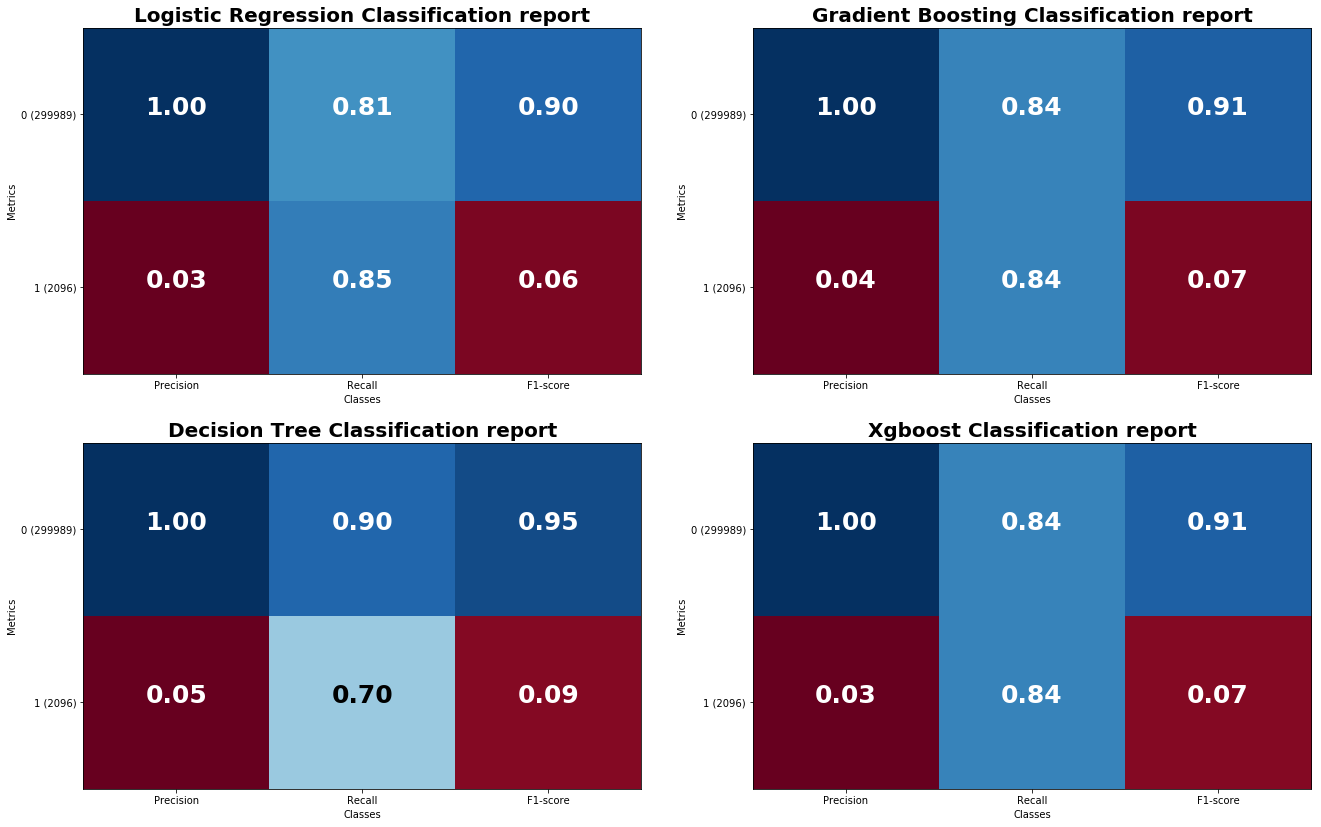

In [55]:
fig, ax = plt.subplots(2, 2,figsize=(22,14))

plot_classification_report_ax(classification_report(sy_test, logregpred)[:166],title='Logistic Regression Classification report',pos=ax[0][0])
plot_classification_report_ax(classification_report(sy_test, gradbpred)[:166],title='Gradient Boosting Classification report',pos=ax[0][1])
plot_classification_report_ax(classification_report(sy_test, dtreepred)[:166],title='Decision Tree Classification report',pos=ax[1][0])
plot_classification_report_ax(classification_report(sy_test, xgbpred)[:166],title='Xgboost Classification report',pos=ax[1][1])
plt.savefig('classification_report_bin.png')
plt.show()


In [103]:
confusion_matrix(sy_test, logregpred)

array([[243635,  56354],
       [   321,   1775]], dtype=int64)

In [104]:
'''
for key, classifier in classifiers.items():
    clafit=classifier.fit(os_data_X, os_data_y)
    alg_lst.append(clafit)
    testing_score = clafit.score( sX_test, sy_test)
    
    print("Classifiers: ", classifier.__class__.__name__, "Has a testing score of {:.2f}".format(testing_score))
 '''   

'\nfor key, classifier in classifiers.items():\n    clafit=classifier.fit(os_data_X, os_data_y)\n    alg_lst.append(clafit)\n    testing_score = clafit.score( sX_test, sy_test)\n    \n    print("Classifiers: ", classifier.__class__.__name__, "Has a testing score of {:.2f}".format(testing_score))\n '

In [105]:
#predictions:
'''
logregpred=alg_lst[0].predict(sX_test)
knpred=alg_lst[1].predict(sX_test)
dtreepred=alg_lst[2].predict(sX_test)
xgbpred=alg_lst[3].predict(sX_test)
'''

'\nlogregpred=alg_lst[0].predict(sX_test)\nknpred=alg_lst[1].predict(sX_test)\ndtreepred=alg_lst[2].predict(sX_test)\nxgbpred=alg_lst[3].predict(sX_test)\n'

In [56]:
logregpred=pickle.load(open('logregModel_binrev.sav', 'rb')).predict_proba(sX_test)[:,1]



In [57]:
logregpred

array([7.96196954e-01, 5.87461036e-06, 5.73869490e-01, ...,
       3.68982253e-02, 2.63164195e-01, 1.00034134e-04])

In [58]:
dtreepred=pickle.load(open('dtreeModel_binrev.sav', 'rb')).predict_proba(sX_test)[:,1]
xgbpred=pickle.load(open('XGBModel_binrev.sav', 'rb')).predict_proba(sX_test)[:,1]
gradbpred=pickle.load(open('gradientbModel_binrev.sav', 'rb')).predict_proba(sX_test)[:,1]

In [59]:
log_fpr, log_tpr, log_thresold = roc_curve(sy_test, logregpred)

In [60]:
log_fpr, log_tpr, log_thresold = roc_curve(sy_test, logregpred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(sy_test, dtreepred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(sy_test, xgbpred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(sy_test, gradbpred)


In [61]:
log_fpr

array([0.        , 0.        , 0.        , ..., 0.99982999, 0.99983666,
       1.        ])

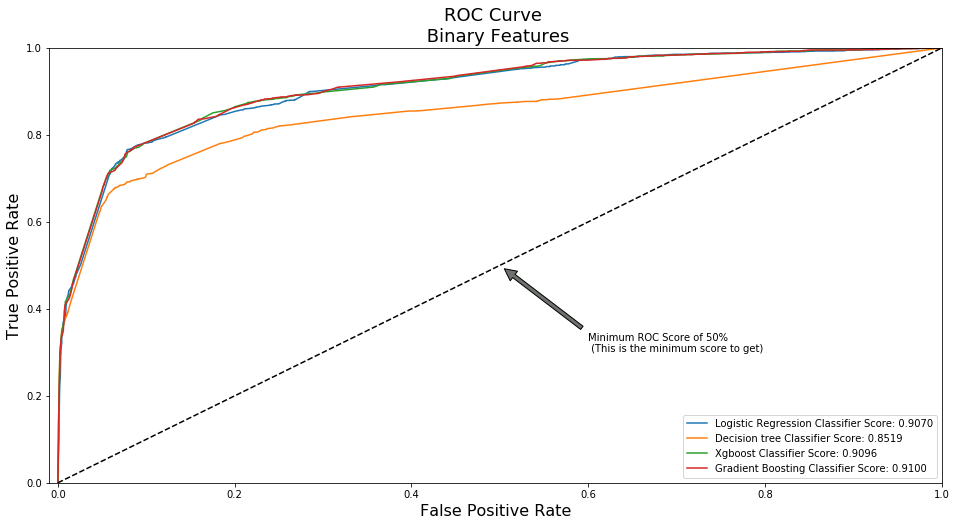

In [62]:


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Binary Features', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(sy_test, logregpred)))
    plt.plot(knear_fpr, knear_tpr, label='Decision tree Classifier Score: {:.4f}'.format(roc_auc_score(sy_test, dtreepred)))
    plt.plot(svc_fpr, svc_tpr, label='Xgboost Classifier Score: {:.4f}'.format(roc_auc_score(sy_test, xgbpred)))
    plt.plot(tree_fpr, tree_tpr, label='Gradient Boosting Classifier Score: {:.4f}'.format(roc_auc_score(sy_test, gradbpred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.savefig('roc1.png')
plt.show()

## Auto Encoder Model

The point of using autoencoders is to use the input data as its own label, and come up with some useful intermediate representation (encoding). Then when running a prediction, and feeding in input data that does not fit well to the intermediate representation, then output signal that it does not fit well. This is known as **Reconstruction Error**.

For this reason we drop the fraudulant data from the training, in order to come up with an encoding for "normal" (non-fraudulant) transactions. After the model is trained, the hope is that feeding in fraudulant data will easily be flagged.

In [113]:
import gc
gc.collect()

23446

In [114]:
univ2=univ1.drop(['OCIF_id'],axis = 1)

In [115]:
univ2.shape

(1006950, 43)

In [116]:
# split the data 70/30, training to testing
train_x, test_x = train_test_split(univ2, test_size=0.25, random_state=10)


In [117]:
train_x.shape

(755212, 43)

In [118]:
test_x.shape

(251738, 43)

In [119]:
train_x.columns

Index(['trn144', 'tsy180', 'tsy189', 'trn038', 'trn008', 'mob053', 'trn054',
       'act041', 'mob081', 'mob070', 'ivr076', 'mob043', 'mob024', 'trn064',
       'trn155', 'tsy182', 'mob033', 'ivr065', 'trn281', 'mob025', 'trn078',
       'mob119', 'ivr024', 'ivr013', 'trn085', 'trn143', 'trn224', 'trn089',
       'trn144_trn008', 'trn126', 'trn060', 'mob029', 'trn280', 'trn142',
       'mob082', 'trn059', 'mob044', 'mob050', 'mob098', 'hub002', 'trn148',
       'act073', 'attrited'],
      dtype='object')

In [120]:

# take out the attrited transactions from training data
attri_df = train_x[train_x['attrited'] == 1]
# keep only normala transaction data in training set
train_x = train_x[train_x['attrited'] == 0]

train_y=train_x['attrited']
# drop the class column (labels) from training set
train_x = train_x.drop(['attrited'], axis=1)

# create labels for test data
test_y = test_x['attrited']
# drop the labels from test data itself
test_x = test_x.drop(['attrited'], axis=1)


In [121]:
train_y.shape

(750019,)

In [122]:

# transform to ndarray
train_x = train_x.values
test_x = test_x.values

In [123]:
# take out labels from remaining fraud data (taken out from training set)
attri_y = attri_df['attrited']
attri_x = attri_df.drop(['attrited'], axis=1).values

# extend test data and label with additional attri. data
test_x_extended = np.concatenate((attri_x, test_x), axis=0)
test_y_extended = pd.concat([attri_y, test_y])

In [124]:
# model train
nb_epoch = 30
batch_size = 256
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 25
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

In [125]:
attri_df.head()

,trn144,tsy180,tsy189,trn038,trn008,mob053,trn054,act041,mob081,mob070,...,trn142,mob082,trn059,mob044,mob050,mob098,hub002,trn148,act073,attrited
389957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
704699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
404318,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
864474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
522984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [126]:


input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [127]:
np.unique(train_y, return_counts=True)

(array([0], dtype=int64), array([750019], dtype=int64))

In [128]:
np.unique(test_y, return_counts=True)

(array([0, 1], dtype=int64), array([249981,   1757], dtype=int64))

In [129]:
train_x.shape

(750019, 42)

In [130]:
test_x.shape

(251738, 42)

In [131]:
#use standard scalar to fit transform data

scaler = StandardScaler()
scaled_trainx=scaler.fit_transform(train_x)

In [132]:
scaled_testx=scaler.fit_transform(test_x)

In [133]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_attr_bin.h5",
                               save_best_only=True,
                               verbose=0)

history = autoencoder.fit(scaled_trainx, scaled_trainx,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(scaled_testx, scaled_testx),
                    verbose=1,
                    callbacks=[cp]).history

Instructions for updating:
Use tf.cast instead.
Train on 750019 samples, validate on 251738 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
750019/750019 [==============================] - 16s 21us/sample - loss: 0.4822 - acc: 0.6193 - val_loss: 0.3279 - val_acc: 0.7885
Epoch 2/30
750019/750019 [==============================] - 13s 17us/sample - loss: 0.2966 - acc: 0.8016 - val_loss: 0.2730 - val_acc: 0.8174
Epoch 3/30
750019/750019 [==============================] - 14s 18us/sample - loss: 0.2630 - acc: 0.8136 - val_loss: 0.2537 - val_acc: 0.8166
Epoch 4/30
750019/750019 [==============================] - 16s 21us/sample - loss: 0.2490 - acc: 0.8181 - val_loss: 0.2442 - val_acc: 0.8119
Epoch 5/30
750019/750019 [==============================] - 16s 22us/sample - loss: 0.2414 - acc: 0.8198 - val_loss: 0.2383 - val_acc: 0.8254
Epoch 6/30
750019/750019 [==============================] - 17s 23us/sample - loss: 0.2364 - acc: 0.8217 - val_loss: 0.2343 - val_acc: 0.8224


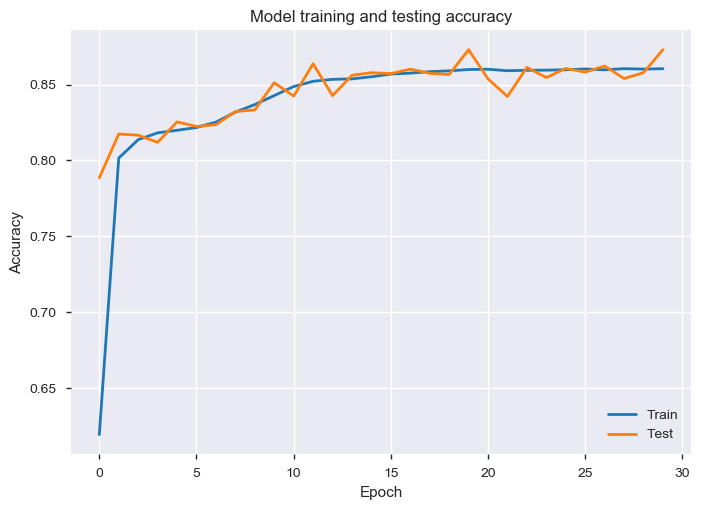

In [134]:
plt.plot(history['acc'], linewidth=2, label='Train')
plt.plot(history['val_acc'], linewidth=2, label='Test')
plt.legend(loc='lower right')
plt.title('Model training and testing accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [135]:
autoencoder = load_model('autoencoder_attr_bin.h5')

In [136]:
scaled_testx_ext=scaler.fit_transform(test_x_extended)

In [137]:
preds = autoencoder.predict(scaled_testx_ext)

In [138]:

mse = np.mean(np.power(test_x_extended - preds, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'Actual': test_y_extended})
error_df.describe()

,Actual,Reconstruction_error
count,256931.00000,256931.000000
mean,0.02705,0.491264
std,0.16223,1.624466
min,0.00000,0.000018
25%,0.00000,0.006761
50%,0.00000,0.103406
75%,0.00000,0.371791
max,1.00000,30.134876


In [108]:
#add stats for the reconstr. erro

(array([2.48788e+05, 5.68600e+03, 8.37000e+02, 4.04000e+02, 3.57000e+02,
        1.89000e+02, 1.74000e+02, 3.55000e+02, 7.20000e+01, 6.90000e+01]),
 array([1.75434086e-05, 3.01350340e+00, 6.02698925e+00, 9.04047511e+00,
        1.20539610e+01, 1.50674468e+01, 1.80809327e+01, 2.10944185e+01,
        2.41079044e+01, 2.71213902e+01, 3.01348761e+01]),
 <a list of 10 Patch objects>)

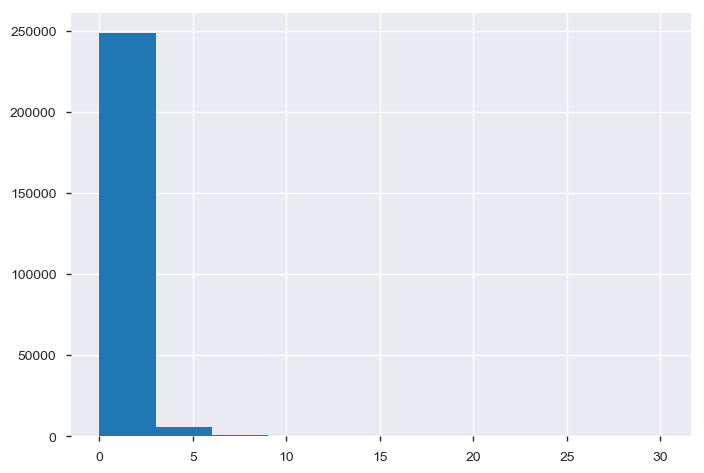

In [139]:
plt.hist(error_df['Reconstruction_error'])

In [140]:
num_attr = error_df.Actual[error_df.Actual == 1].count()
num_normal = error_df.Actual[error_df.Actual == 0].count()
no_skill_level = num_attr/(num_attr + num_normal)

num_attr, num_normal, no_skill_level

(6950, 249981, 0.027050064024971687)

In [141]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Actual, error_df.Reconstruction_error)

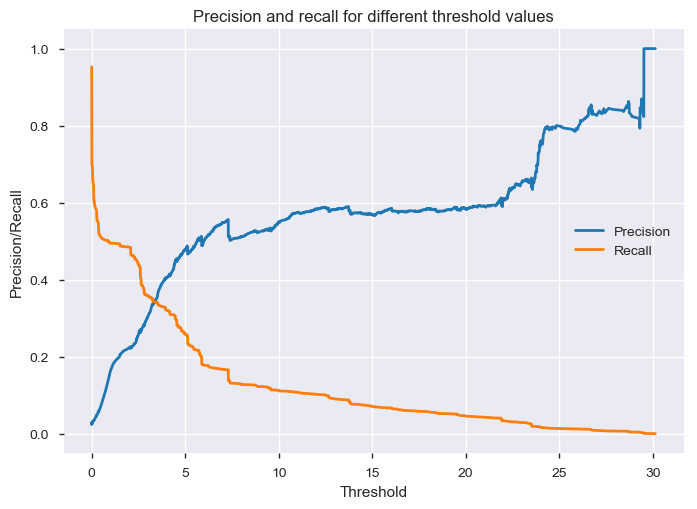

In [142]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [203]:
threshold_fixed=0.0006

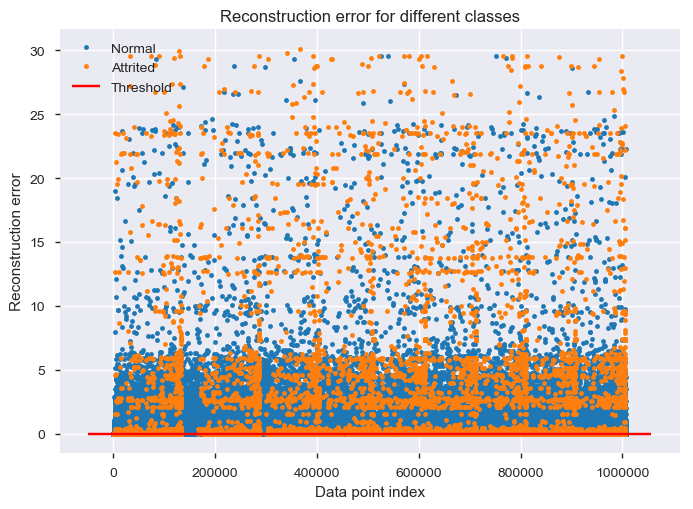

In [204]:

groups = error_df.groupby('Actual')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attrited" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [200]:
preds_y_binary = [1 if e > 0.0006 else 0 for e in error_df.Reconstruction_error]

print(classification_report(test_y_extended, preds_y_binary))

              precision    recall  f1-score   support

           0       0.95      0.14      0.25    249981
           1       0.02      0.74      0.05      6950

    accuracy                           0.16    256931
   macro avg       0.49      0.44      0.15    256931
weighted avg       0.93      0.16      0.24    256931



In [201]:
conf_matrix = confusion_matrix(error_df.Actual, preds_y_binary)
conf_matrix

array([[ 35961, 214020],
       [  1783,   5167]], dtype=int64)

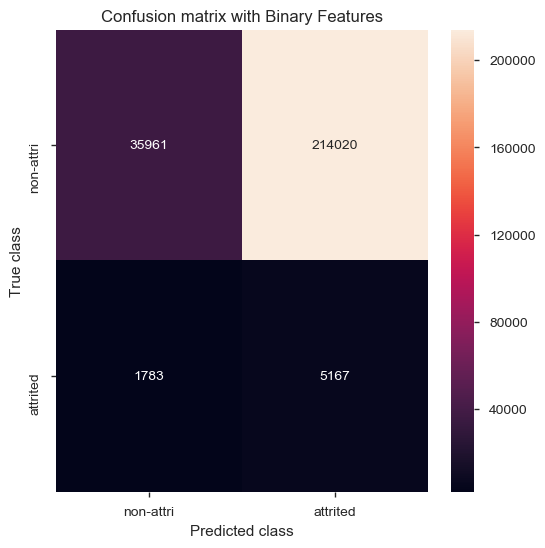

In [202]:
LABELS = ["non-attri","attrited"]
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix with Binary Features")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()